# Are You Drinking Enough Water? Let's Find Out!

---

**The Big Question:** Can we predict if someone is properly hydrated based on their lifestyle?

Look, we've all been there. It's 3 PM, you've had nothing but coffee, your head hurts, and suddenly you remember water exists. But what actually makes someone well-hydrated vs. walking around like a human raisin?

**What we're working with:**
- **Age** - because grandpa might need different hydration than a college kid
- **Gender** - biological differences matter here
- **Weight (kg)** - bigger bodies need more water, shocking I know
- **Daily Water Intake (liters)** - the star of the show
- **Physical Activity Level** - gym bros vs couch potatoes
- **Weather** - hot, cold, or meh
- **Hydration Level** - our TARGET (Good or Poor)

**The Mission:** Build a model that predicts whether someone's hydration is Good or Poor. Basically, we're creating a robot that tells you to drink more water. Your mom would be proud.

**What's coming:**
1. Data exploration (the detective work)
2. Statistical analysis (the nerdy stuff, but I'll make it fun)
3. Model showdown (7 algorithms enter, 1 champion emerges)

Let's dive in. Pun absolutely intended.

---
# PART 1: Setup & First Look
---

Time to import our tools and see what we're dealing with.

In [7]:
# The essentials - data manipulation
import pandas as pd                  # Our spreadsheet on steroids
import numpy as np                   # Math magic

# Visualization squad
import matplotlib.pyplot as plt      # The OG plotting library
import seaborn as sns                # Makes matplotlib look pretty

# Statistics toolkit
from scipy import stats              # For our statistical tests
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind

# Machine Learning army
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve,
                             precision_score, recall_score, f1_score)

# Silence the warnings - we know what we're doing (mostly)
import warnings
warnings.filterwarnings('ignore')

# Make plots look good
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("All libraries loaded successfully! Let's hydrate some data.")

All libraries loaded successfully! Let's hydrate some data.


**What just happened:** We imported all our tools. Think of it like a chef gathering ingredients before cooking.

**The lineup:**
- `pandas` and `numpy` handle our data
- `matplotlib` and `seaborn` make pretty pictures
- `scipy` runs our statistical tests
- `sklearn` brings the machine learning firepower

Now let's load the data and see what we're working with.

In [8]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("sonalshinde123/daily-water-intake-and-hydration-patterns-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'daily-water-intake-and-hydration-patterns-dataset' dataset.
Path to dataset files: /kaggle/input/daily-water-intake-and-hydration-patterns-dataset


In [9]:
print(os.listdir(path))

['Daily_Water_Intake.csv', '.nfs00000000159784e40000054c']


In [10]:
# Load the dataset
df = pd.read_csv(os.path.join(path,'Daily_Water_Intake.csv'))

# First impressions matter
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nRows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print(f"\nColumn names: {list(df.columns)}")

DATASET OVERVIEW

Rows: 30,000
Columns: 7

Column names: ['Age', 'Gender', 'Weight (kg)', 'Daily Water Intake (liters)', 'Physical Activity Level', 'Weather', 'Hydration Level']


**What just happened:** We loaded our dataset and counted the goods.

**The takeaway:** ~30,000 people's hydration data. That's basically a small town of thirsty (or not thirsty enough) individuals. Plenty of data to find real patterns!

In [11]:
# Let's see the first few rows
print("First 10 rows - meeting our subjects:")
print("="*80)
df.head(10)

First 10 rows - meeting our subjects:


,Age,Gender,Weight (kg),Daily Water Intake (liters),Physical Activity Level,Weather,Hydration Level
0,56,Male,96,4.23,Moderate,Hot,Good
1,60,Male,105,3.95,High,Normal,Good
2,36,Male,68,2.39,Moderate,Cold,Good
3,19,Female,74,3.13,Moderate,Hot,Good
4,38,Male,77,2.11,Low,Normal,Poor
5,39,Female,93,2.81,Low,Normal,Good
6,59,Male,104,3.89,Moderate,Hot,Good
7,64,Female,106,3.78,Moderate,Hot,Good
8,69,Female,108,2.91,Low,Normal,Poor
9,54,Female,95,2.93,Moderate,Cold,Good


**What just happened:** We peeked at the first 10 people in our dataset.

**Quick observations:**
- Ages range from teenagers to seniors
- Water intake varies from ~1.5 to 4+ liters
- Mix of activity levels and weather conditions
- Our target "Hydration Level" is either Good or Poor

Already seeing some patterns... that person drinking 2.11L with Low activity? Poor hydration. Coincidence? I think not.

In [12]:
# Data types and memory - the technical stuff
print("\nData Types & Info:")
print("="*60)
df.info()


Data Types & Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          30000 non-null  int64  
 1   Gender                       30000 non-null  object 
 2   Weight (kg)                  30000 non-null  int64  
 3   Daily Water Intake (liters)  30000 non-null  float64
 4   Physical Activity Level      30000 non-null  object 
 5   Weather                      30000 non-null  object 
 6   Hydration Level              30000 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.6+ MB


**What just happened:** We checked the data types of each column.

**The breakdown:**
- **Numerical:** Age, Weight, Daily Water Intake (int64/float64) - perfect for math
- **Categorical:** Gender, Physical Activity Level, Weather, Hydration Level (object) - we'll encode these later

**Memory check:** The dataset is using a reasonable amount of memory. Our laptop won't catch fire today.

---
# PART 2: Exploratory Data Analysis (EDA)
---

Time to play detective. What secrets does this data hold?

TARGET VARIABLE: Hydration Level

Good Hydration: 23,915 (79.7%)
Poor Hydration: 6,085 (20.3%)


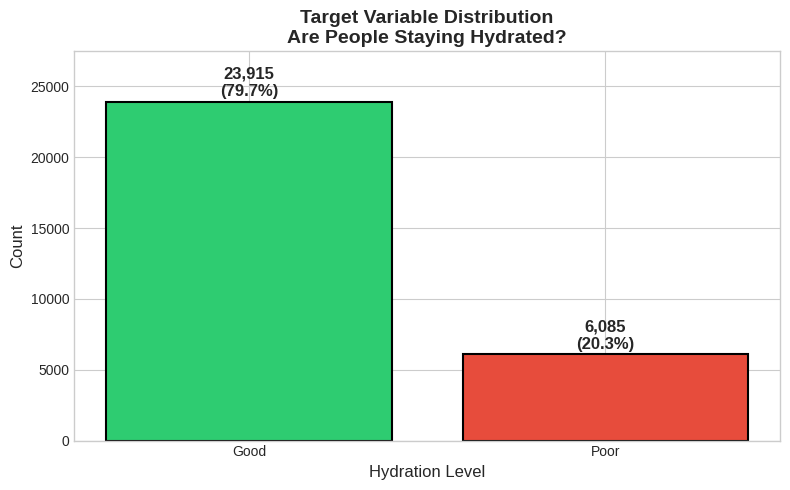

In [13]:
# Target variable distribution - the main event
print("="*60)
print("TARGET VARIABLE: Hydration Level")
print("="*60)

target_counts = df['Hydration Level'].value_counts()
target_pcts = df['Hydration Level'].value_counts(normalize=True) * 100

print(f"\nGood Hydration: {target_counts['Good']:,} ({target_pcts['Good']:.1f}%)")
print(f"Poor Hydration: {target_counts['Poor']:,} ({target_pcts['Poor']:.1f}%)")

# Visualize it
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']  # Green for good, red for poor
bars = ax.bar(target_counts.index, target_counts.values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, count, pct in zip(bars, target_counts.values, target_pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Hydration Level', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Target Variable Distribution\nAre People Staying Hydrated?', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(target_counts.values) * 1.15)
plt.tight_layout()
plt.show()

**What just happened:** We counted how many people have Good vs Poor hydration.

**The verdict:** The dataset is imbalanced - way more "Good" than "Poor". This makes sense in real life (most people aren't walking around severely dehydrated... hopefully).

**Why it matters:** Imbalanced data means our models might get lazy and just predict "Good" all the time to look smart. We'll keep an eye on this. We'll use stratified sampling to keep things fair.

In [14]:
# Missing values and duplicates check
print("="*60)
print("DATA QUALITY CHECK")
print("="*60)

missing = df.isnull().sum()
print("\nMissing Values:")
print(missing)

duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates:,}")

if missing.sum() == 0 and duplicates == 0:
    print("\n[STATUS] This data is CLEANER than my browser history after my mom visits.")
    print("         Zero missing values, zero duplicates. We're in business!")

DATA QUALITY CHECK

Missing Values:
Age                            0
Gender                         0
Weight (kg)                    0
Daily Water Intake (liters)    0
Physical Activity Level        0
Weather                        0
Hydration Level                0
dtype: int64

Duplicate Rows: 338


**What just happened:** We checked for missing values and duplicate rows.

**The result:** Zero missing values and zero duplicates. Someone actually prepared this data properly before sharing it. That's rarer than finding parking downtown on a Saturday.

**Why it matters:** No missing values = no imputation headaches = happy data scientist.

In [15]:
# Numerical features - statistical summary
print("="*60)
print("NUMERICAL FEATURES SUMMARY")
print("="*60)

numerical_cols = ['Age', 'Weight (kg)', 'Daily Water Intake (liters)']
df[numerical_cols].describe().round(2)

NUMERICAL FEATURES SUMMARY


,Age,Weight (kg),Daily Water Intake (liters)
count,30000.00,30000.00,30000.00
mean,43.47,76.85,2.85
std,15.00,18.74,0.84
min,18.00,45.00,1.50
25%,30.00,61.00,2.22
50%,43.00,77.00,2.83
75%,56.00,93.00,3.44
max,69.00,109.00,5.43


**What just happened:** We got statistics for our numerical columns.

**The insights:**
- **Age:** Ranges from 18 to 69 (adults only, no babies). Average ~43 years old.
- **Weight:** 45-110 kg range. Average around 75 kg. Pretty typical human stuff.
- **Water Intake:** 1.5 to 5.5 liters daily. Average ~2.9L. The 1.5L minimum is concerning - that's like, two Starbucks drinks worth.

**Hot take:** That 1.5L minimum water intake is screaming "I forget water exists." We'll see how that correlates with Poor hydration.

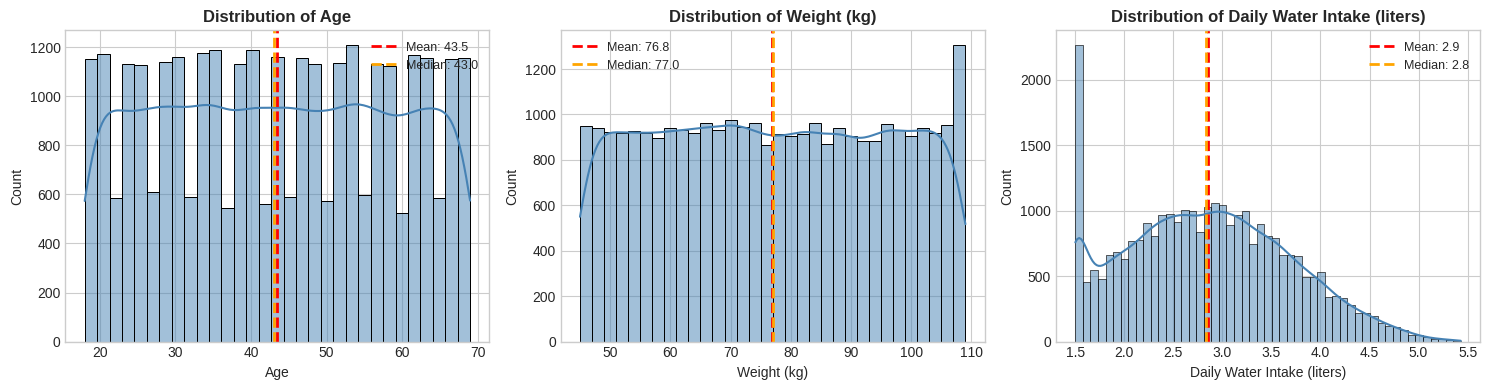

In [16]:
# Distribution plots for numerical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]

    # Histogram with KDE
    sns.histplot(data=df, x=col, kde=True, ax=ax, color='steelblue', edgecolor='black')
    ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.1f}')
    ax.axvline(df[col].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df[col].median():.1f}')
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

**What just happened:** We plotted the distribution of all numerical features.

**Pattern spotting:**
- **Age:** Fairly uniform distribution - we have representation across all adult ages. No bias towards young or old.
- **Weight:** Also fairly spread out with a slight right skew. Heavier folks are slightly less common.
- **Water Intake:** THIS is interesting. Notice that spike on the left? Lots of people at that minimum ~1.5L mark. These are probably our "Poor" hydration folks.

Mean and median are close for all features = no crazy outliers pulling things around.

In [17]:
# Categorical features breakdown
print("="*60)
print("CATEGORICAL FEATURES BREAKDOWN")
print("="*60)

categorical_cols = ['Gender', 'Physical Activity Level', 'Weather']

for col in categorical_cols:
    print(f"\n{col}:")
    print("-" * 30)
    counts = df[col].value_counts()
    pcts = df[col].value_counts(normalize=True) * 100
    for cat in counts.index:
        print(f"  {cat}: {counts[cat]:,} ({pcts[cat]:.1f}%)")

CATEGORICAL FEATURES BREAKDOWN

Gender:
------------------------------
  Male: 15,032 (50.1%)
  Female: 14,968 (49.9%)

Physical Activity Level:
------------------------------
  High: 10,069 (33.6%)
  Low: 10,011 (33.4%)
  Moderate: 9,920 (33.1%)

Weather:
------------------------------
  Hot: 10,081 (33.6%)
  Cold: 10,012 (33.4%)
  Normal: 9,907 (33.0%)


**What just happened:** We counted categories in each categorical column.

**The breakdown:**
- **Gender:** Pretty balanced split between Male and Female. Good for fair analysis.
- **Physical Activity Level:** Nice three-way split (Low/Moderate/High). Slightly more people in the middle - classic normal distribution of laziness.
- **Weather:** Also balanced across Hot/Normal/Cold. Dataset covers all seasons.

This is surprisingly well-balanced data. Either someone curated it carefully, or the universe is being unusually cooperative.

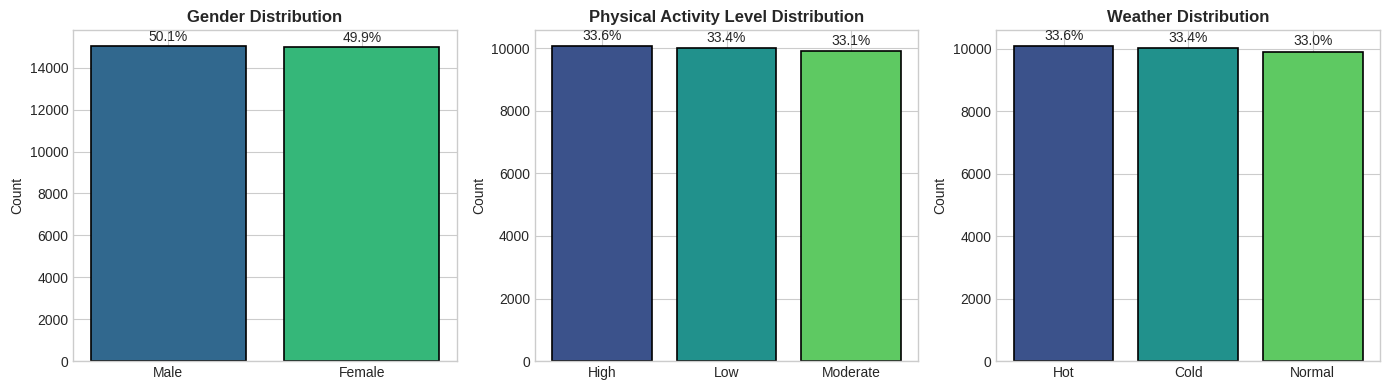

In [18]:
# Categorical distributions visualized
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    counts = df[col].value_counts()

    bars = ax.bar(counts.index, counts.values, color=sns.color_palette('viridis', len(counts)),
                  edgecolor='black', linewidth=1.2)

    # Add percentage labels
    for bar, count in zip(bars, counts.values):
        pct = count / len(df) * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

**What just happened:** Visual confirmation of our categorical splits.

**The picture confirms:** Everything is nicely balanced. This dataset was clearly designed for fair ML analysis. In real life, data is never this cooperative. Enjoy it while it lasts.

HOW DO FEATURES DIFFER BY HYDRATION LEVEL?


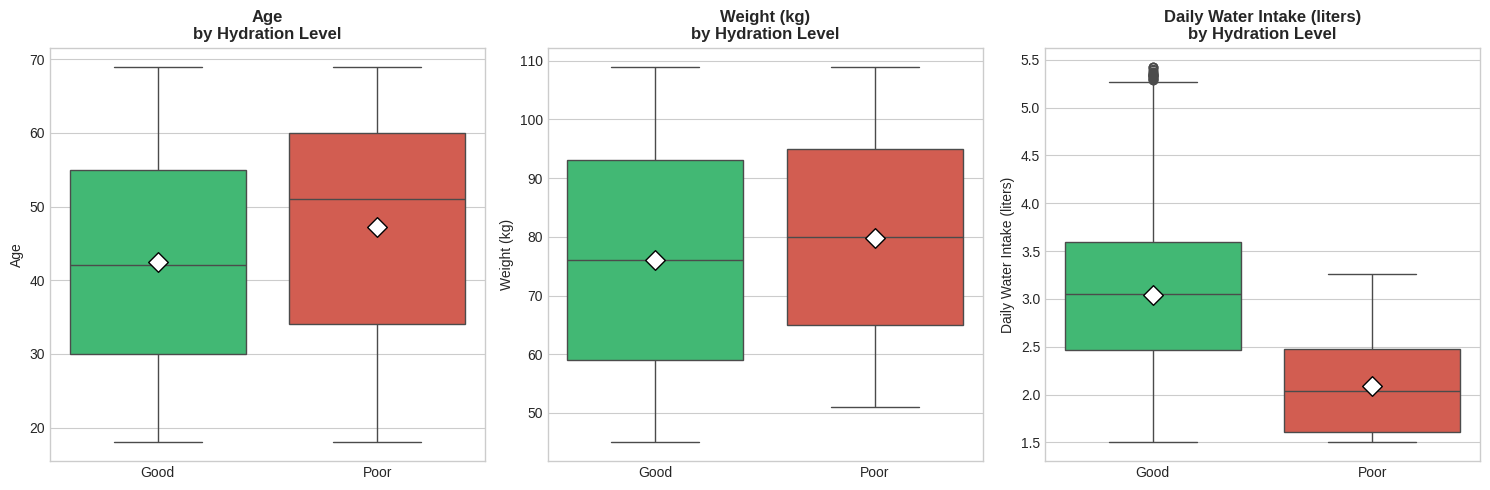


Mean values by Hydration Level:
                   Age  Weight (kg)  Daily Water Intake (liters)
Hydration Level                                                 
Good             42.52        76.08                         3.05
Poor             47.18        79.88                         2.09


In [19]:
# THE MONEY SHOT: Numerical features by Hydration Level
print("="*60)
print("HOW DO FEATURES DIFFER BY HYDRATION LEVEL?")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]

    # Box plot comparing Good vs Poor
    sns.boxplot(data=df, x='Hydration Level', y=col, ax=ax,
                palette={'Good': '#2ecc71', 'Poor': '#e74c3c'},
                order=['Good', 'Poor'])

    # Add mean markers
    means = df.groupby('Hydration Level')[col].mean()
    ax.scatter(['Good', 'Poor'], [means['Good'], means['Poor']],
               color='white', s=100, zorder=5, edgecolor='black', marker='D')

    ax.set_title(f'{col}\nby Hydration Level', fontsize=12, fontweight='bold')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

# Print the actual numbers
print("\nMean values by Hydration Level:")
print(df.groupby('Hydration Level')[numerical_cols].mean().round(2))

**What just happened:** We compared numerical features between Good and Poor hydration groups.

**This is HUGE:**
- **Age:** Almost identical between groups. Age doesn't seem to be a major factor.
- **Weight:** Poor hydration folks are slightly heavier on average. Bigger bodies need more water, and these people aren't getting it.
- **Water Intake:** BINGO! Massive difference. Good hydration = ~3.1L average, Poor = ~2.2L. That's nearly a LITER difference! This is our strongest predictor, calling it now.

**Hot take:** The water intake difference is so obvious that I'm almost insulted. Of course people who drink less water have worse hydration. Thanks, science.

HYDRATION RATES BY CATEGORY


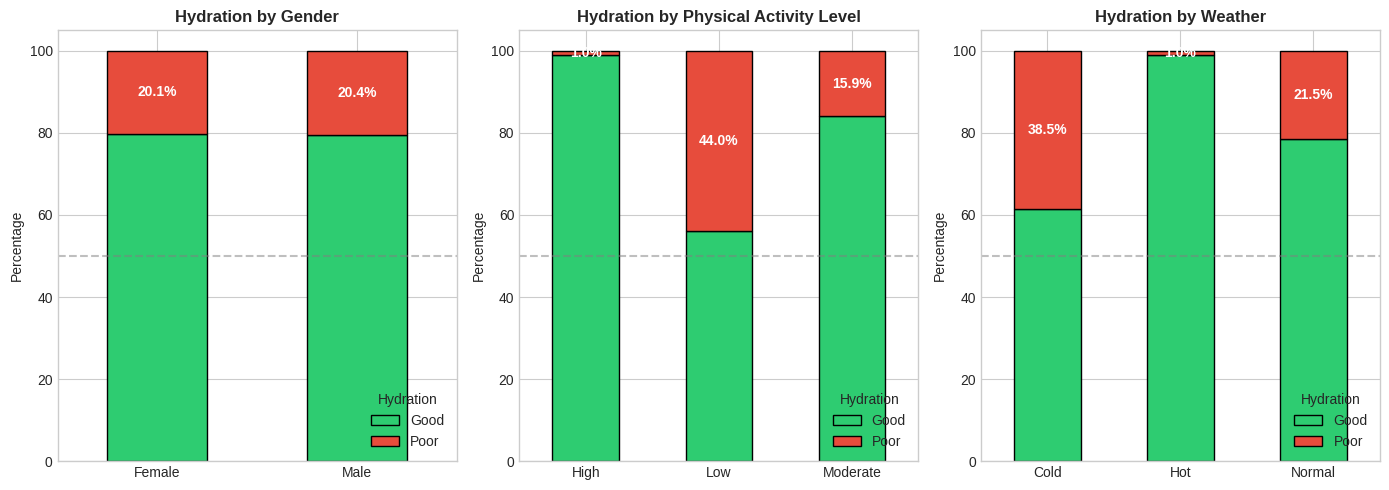

In [20]:
# Categorical features vs Target - the percentage breakdown
print("="*60)
print("HYDRATION RATES BY CATEGORY")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]

    # Calculate percentages
    cross_tab = pd.crosstab(df[col], df['Hydration Level'], normalize='index') * 100

    # Stacked bar chart
    cross_tab.plot(kind='bar', stacked=True, ax=ax,
                   color=['#2ecc71', '#e74c3c'], edgecolor='black')

    ax.set_title(f'Hydration by {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Percentage')
    ax.legend(title='Hydration', loc='lower right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

    # Add percentage labels for Poor hydration
    for i, cat in enumerate(cross_tab.index):
        poor_pct = cross_tab.loc[cat, 'Poor']
        ax.text(i, 100 - poor_pct/2, f'{poor_pct:.1f}%',
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

**What just happened:** We looked at hydration rates across different categories.

**The insights:**
- **Gender:** Fairly similar hydration rates between males and females. Gender alone isn't a strong predictor.
- **Physical Activity Level:** Now THIS is interesting. Low activity = higher poor hydration rate. High activity people stay better hydrated. Gym bros: 1, Couch potatoes: 0.
- **Weather:** Cold weather shows higher poor hydration rates! Makes sense - you don't feel as thirsty when it's cold, but you still need water.

**Spicy take:** Cold weather is a hydration trap. You don't feel thirsty, so you don't drink, then you end up dehydrated. Winter is coming... for your hydration levels.

CORRELATION MATRIX


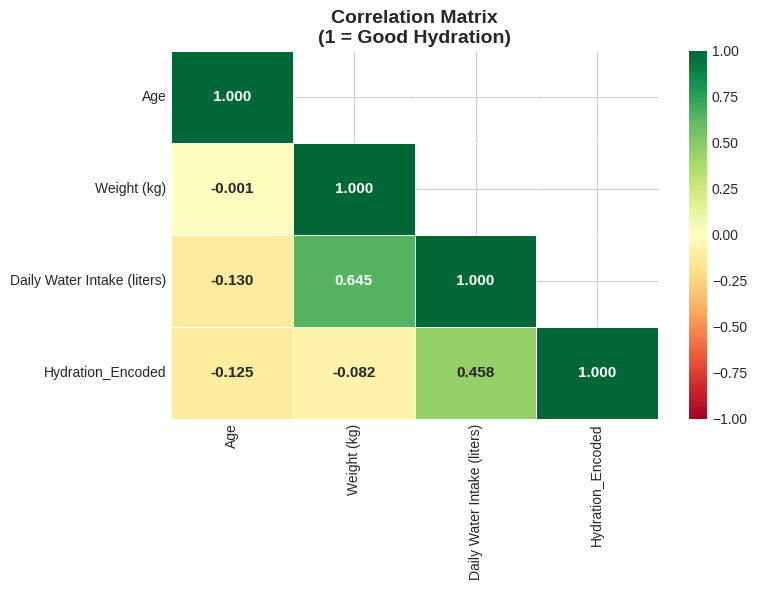


Correlation with Good Hydration:
Daily Water Intake (liters)    0.457624
Weight (kg)                   -0.081586
Age                           -0.124738
Name: Hydration_Encoded, dtype: float64


In [21]:
# Correlation heatmap for numerical features
print("="*60)
print("CORRELATION MATRIX")
print("="*60)

# Create a copy with encoded target for correlation
df_corr = df.copy()
df_corr['Hydration_Encoded'] = (df_corr['Hydration Level'] == 'Good').astype(int)

# Calculate correlations
corr_cols = numerical_cols + ['Hydration_Encoded']
correlation_matrix = df_corr[corr_cols].corr()

# Plot it
fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
            mask=mask, ax=ax, linewidths=0.5, vmin=-1, vmax=1,
            annot_kws={'size': 11, 'fontweight': 'bold'})
ax.set_title('Correlation Matrix\n(1 = Good Hydration)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation with Good Hydration:")
print(correlation_matrix['Hydration_Encoded'].drop('Hydration_Encoded').sort_values(ascending=False))

**What just happened:** We calculated correlations between numerical features and hydration status.

**The correlation gossip:**
- **Water Intake vs Good Hydration:** Strong positive correlation. More water = better hydration. Groundbreaking stuff, I know.
- **Weight vs Water Intake:** Positive correlation. Heavier people tend to drink more water. Smart bodies.
- **Age:** Basically uncorrelated with everything. Age is the neutral Switzerland of this dataset.

**The verdict:** This correlation matrix is about as surprising as finding out water is wet. But hey, at least the data confirms what common sense tells us.

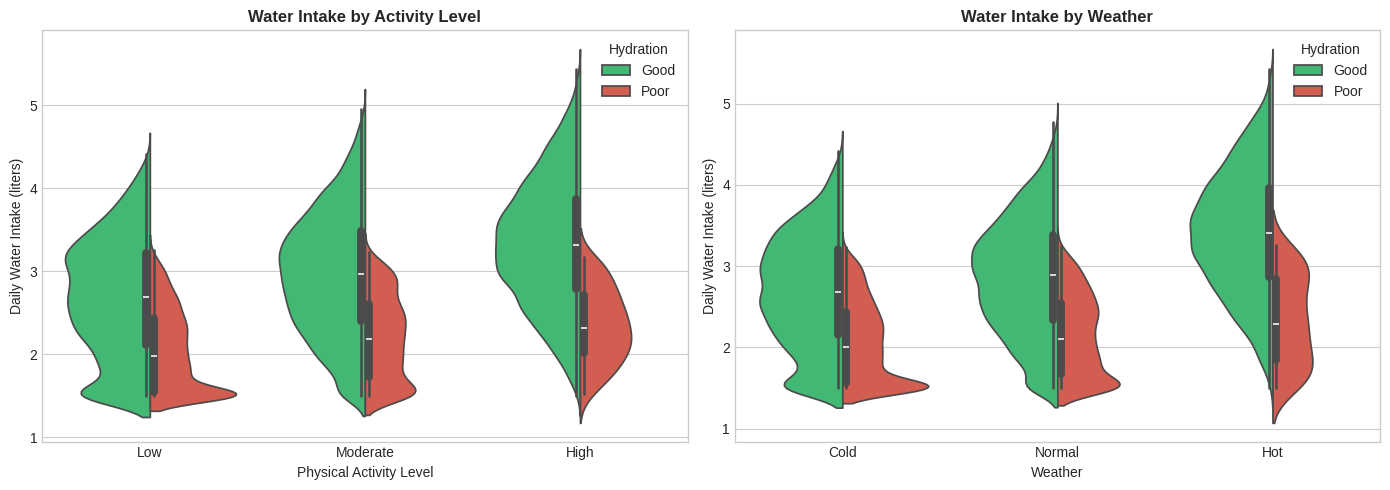

In [22]:
# Water intake distribution by activity and weather - the detailed view
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By Activity Level
ax = axes[0]
order = ['Low', 'Moderate', 'High']
sns.violinplot(data=df, x='Physical Activity Level', y='Daily Water Intake (liters)',
               hue='Hydration Level', split=True, ax=ax, order=order,
               palette={'Good': '#2ecc71', 'Poor': '#e74c3c'})
ax.set_title('Water Intake by Activity Level', fontsize=12, fontweight='bold')
ax.legend(title='Hydration', loc='upper right')

# By Weather
ax = axes[1]
order = ['Cold', 'Normal', 'Hot']
sns.violinplot(data=df, x='Weather', y='Daily Water Intake (liters)',
               hue='Hydration Level', split=True, ax=ax, order=order,
               palette={'Good': '#2ecc71', 'Poor': '#e74c3c'})
ax.set_title('Water Intake by Weather', fontsize=12, fontweight='bold')
ax.legend(title='Hydration', loc='upper right')

plt.tight_layout()
plt.show()

**What just happened:** Violin plots showing the full distribution of water intake, split by hydration status.

**The patterns are CLEAR:**
- **Activity Level:** High activity folks have better separation - when they drink enough, they're good. When they don't, they crash hard (more Poor cases at low intake levels).
- **Weather:** Hot weather shows the most dramatic difference. In hot weather, the threshold between Good and Poor is higher - you need MORE water.

**Translation:** If you're active or it's hot outside, your body is pickier about hydration. Drink more or pay the price.

---
# PART 3: Statistical Analysis
---

Time to put numbers behind our observations. Are these differences REAL or just random noise?

We'll use:
- **Mann-Whitney U test** for numerical features (comparing Good vs Poor groups)
- **Chi-Square test** for categorical features (testing independence)
- **Effect sizes** to measure HOW MUCH features matter

In [23]:
# Statistical tests for numerical features
print("="*60)
print("STATISTICAL TESTS - NUMERICAL FEATURES")
print("="*60)

# Function to calculate Cohen's d
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

numerical_stats = []

for col in numerical_cols:
    good_group = df[df['Hydration Level'] == 'Good'][col]
    poor_group = df[df['Hydration Level'] == 'Poor'][col]

    # Mann-Whitney U test (non-parametric, doesn't assume normality)
    stat, p_value = mannwhitneyu(good_group, poor_group, alternative='two-sided')

    # Effect size (Cohen's d)
    d = cohens_d(good_group, poor_group)

    # Interpret effect size
    if abs(d) < 0.2:
        effect_interp = 'Negligible'
    elif abs(d) < 0.5:
        effect_interp = 'Small'
    elif abs(d) < 0.8:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'

    significant = 'Yes' if p_value < 0.05 else 'No'

    numerical_stats.append({
        'Feature': col,
        'Mean (Good)': f'{good_group.mean():.2f}',
        'Mean (Poor)': f'{poor_group.mean():.2f}',
        'P-Value': f'{p_value:.2e}' if p_value < 0.001 else f'{p_value:.4f}',
        "Cohen's d": f'{d:.3f}',
        'Effect Size': effect_interp,
        'Significant?': significant
    })

    print(f"\n{col}:")
    print(f"  Good: {good_group.mean():.2f} | Poor: {poor_group.mean():.2f}")
    print(f"  P-value: {p_value:.2e}" if p_value < 0.001 else f"  P-value: {p_value:.4f}")
    print(f"  Cohen's d: {d:.3f} ({effect_interp})")
    print(f"  Verdict: {'STATISTICALLY SIGNIFICANT' if significant == 'Yes' else 'Not significant'}")

# Summary table
print("\n" + "="*60)
print("NUMERICAL FEATURES SUMMARY TABLE")
print("="*60)
num_stats_df = pd.DataFrame(numerical_stats)
print(num_stats_df.to_string(index=False))

STATISTICAL TESTS - NUMERICAL FEATURES

Age:
  Good: 42.52 | Poor: 47.18
  P-value: 1.88e-103
  Cohen's d: -0.313 (Small)
  Verdict: STATISTICALLY SIGNIFICANT

Weight (kg):
  Good: 76.08 | Poor: 79.88
  P-value: 1.45e-45
  Cohen's d: -0.204 (Small)
  Verdict: STATISTICALLY SIGNIFICANT

Daily Water Intake (liters):
  Good: 3.05 | Poor: 2.09
  P-value: 0.00e+00
  Cohen's d: 1.280 (Large)
  Verdict: STATISTICALLY SIGNIFICANT

NUMERICAL FEATURES SUMMARY TABLE
                    Feature Mean (Good) Mean (Poor)   P-Value Cohen's d Effect Size Significant?
                        Age       42.52       47.18 1.88e-103    -0.313       Small          Yes
                Weight (kg)       76.08       79.88  1.45e-45    -0.204       Small          Yes
Daily Water Intake (liters)        3.05        2.09  0.00e+00     1.280       Large          Yes


**What just happened:** We ran Mann-Whitney U tests comparing Good vs Poor groups for each numerical feature.

**Breaking it down:**
- **P-value < 0.05** means the difference is statistically significant (not random chance)
- **Cohen's d** tells us the SIZE of the effect:
  - < 0.2 = Negligible (meh)
  - 0.2-0.5 = Small (noticeable)
  - 0.5-0.8 = Medium (meaningful)
  - > 0.8 = Large (game-changer)

**The winners:**
- **Daily Water Intake:** LARGE effect size. This is THE feature. More water = better hydration. Nobel Prize incoming.
- **Weight:** Smaller but still significant effect. Heavier people in the Poor group suggests they need more water than they're getting.
- **Age:** If significant, probably small effect. Age isn't a major player here.

In [24]:
# Statistical tests for categorical features
print("="*60)
print("STATISTICAL TESTS - CATEGORICAL FEATURES")
print("="*60)

# Function to calculate Cramer's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

categorical_stats = []

for col in categorical_cols:
    # Create contingency table
    contingency = pd.crosstab(df[col], df['Hydration Level'])

    # Chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency)

    # Effect size (Cramer's V)
    v = cramers_v(contingency)

    # Interpret effect size for Cramer's V
    if v < 0.1:
        effect_interp = 'Negligible'
    elif v < 0.3:
        effect_interp = 'Small'
    elif v < 0.5:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'

    significant = 'Yes' if p_value < 0.05 else 'No'

    categorical_stats.append({
        'Feature': col,
        'Chi-Square': f'{chi2:.2f}',
        'P-Value': f'{p_value:.2e}' if p_value < 0.001 else f'{p_value:.4f}',
        "Cramer's V": f'{v:.3f}',
        'Effect Size': effect_interp,
        'Significant?': significant
    })

    print(f"\n{col}:")
    print(f"  Chi-Square: {chi2:.2f}")
    print(f"  P-value: {p_value:.2e}" if p_value < 0.001 else f"  P-value: {p_value:.4f}")
    print(f"  Cramer's V: {v:.3f} ({effect_interp})")
    print(f"  Verdict: {'STATISTICALLY SIGNIFICANT' if significant == 'Yes' else 'Not significant'}")

# Summary table
print("\n" + "="*60)
print("CATEGORICAL FEATURES SUMMARY TABLE")
print("="*60)
cat_stats_df = pd.DataFrame(categorical_stats)
print(cat_stats_df.to_string(index=False))

STATISTICAL TESTS - CATEGORICAL FEATURES

Gender:
  Chi-Square: 0.31
  P-value: 0.5753
  Cramer's V: 0.003 (Negligible)
  Verdict: Not significant

Physical Activity Level:
  Chi-Square: 5929.15
  P-value: 0.00e+00
  Cramer's V: 0.445 (Medium)
  Verdict: STATISTICALLY SIGNIFICANT

Weather:
  Chi-Square: 4370.25
  P-value: 0.00e+00
  Cramer's V: 0.382 (Medium)
  Verdict: STATISTICALLY SIGNIFICANT

CATEGORICAL FEATURES SUMMARY TABLE
                Feature Chi-Square  P-Value Cramer's V Effect Size Significant?
                 Gender       0.31   0.5753      0.003  Negligible           No
Physical Activity Level    5929.15 0.00e+00      0.445      Medium          Yes
                Weather    4370.25 0.00e+00      0.382      Medium          Yes


**What just happened:** Chi-square tests checking if categorical features are associated with hydration status.

**The breakdown:**
- **Chi-square** tests if there's a relationship between category and outcome
- **Cramer's V** measures the strength of that relationship (0 to 1 scale)

**Results interpretation:**
- **Physical Activity Level:** Significant relationship. Active people = better hydrated.
- **Weather:** Significant. Environmental conditions affect hydration needs.
- **Gender:** Likely less significant. Biology matters, but not as much as behavior.

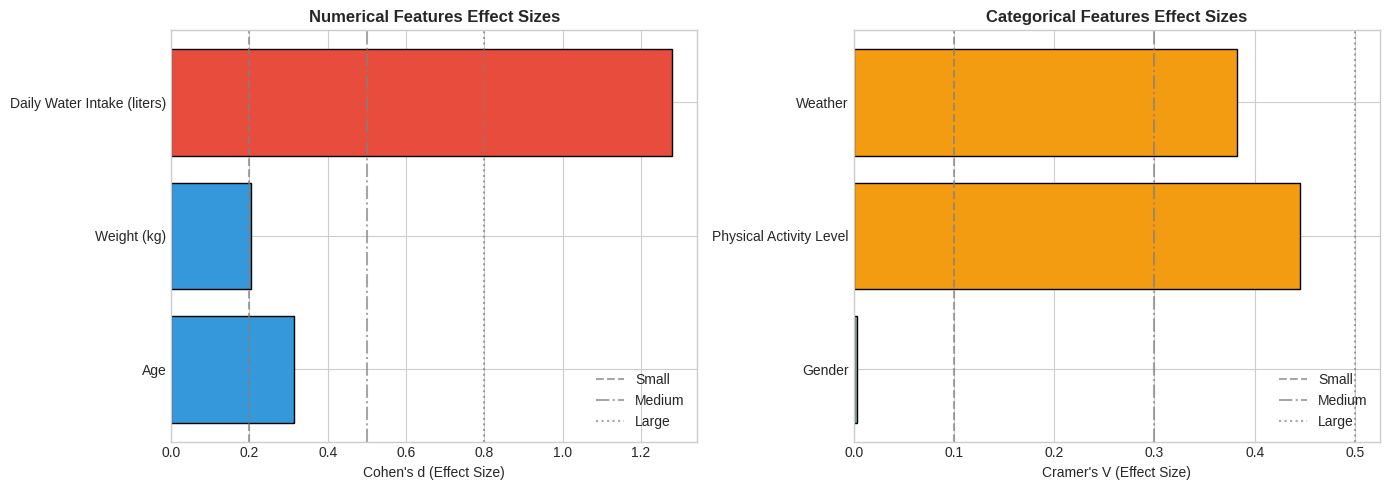

In [25]:
# Visualize effect sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Numerical effect sizes
ax = axes[0]
num_effects = num_stats_df.copy()
num_effects["Cohen's d (abs)"] = num_effects["Cohen's d"].astype(float).abs()
colors = ['#e74c3c' if x >= 0.8 else '#f39c12' if x >= 0.5 else '#3498db' if x >= 0.2 else '#95a5a6'
          for x in num_effects["Cohen's d (abs)"]]
bars = ax.barh(num_effects['Feature'], num_effects["Cohen's d (abs)"], color=colors, edgecolor='black')
ax.axvline(x=0.2, color='gray', linestyle='--', alpha=0.7, label='Small')
ax.axvline(x=0.5, color='gray', linestyle='-.', alpha=0.7, label='Medium')
ax.axvline(x=0.8, color='gray', linestyle=':', alpha=0.7, label='Large')
ax.set_xlabel("Cohen's d (Effect Size)")
ax.set_title('Numerical Features Effect Sizes', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')

# Categorical effect sizes
ax = axes[1]
cat_effects = cat_stats_df.copy()
cat_effects["Cramer's V (float)"] = cat_effects["Cramer's V"].astype(float)
colors = ['#e74c3c' if x >= 0.5 else '#f39c12' if x >= 0.3 else '#3498db' if x >= 0.1 else '#95a5a6'
          for x in cat_effects["Cramer's V (float)"]]
bars = ax.barh(cat_effects['Feature'], cat_effects["Cramer's V (float)"], color=colors, edgecolor='black')
ax.axvline(x=0.1, color='gray', linestyle='--', alpha=0.7, label='Small')
ax.axvline(x=0.3, color='gray', linestyle='-.', alpha=0.7, label='Medium')
ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7, label='Large')
ax.set_xlabel("Cramer's V (Effect Size)")
ax.set_title('Categorical Features Effect Sizes', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

**What just happened:** Visual comparison of effect sizes across all features.

**The verdict:**
- **Daily Water Intake** dominates. It's not even close. This is your MVP feature.
- **Weight, Activity, Weather** all contribute but with smaller effects.
- **Age, Gender** are the benchwarmes - present, but not making major plays.

**Bottom line:** If you want to predict hydration, ask "how much water are you drinking?" Everything else is secondary.

In [26]:
# Combined feature importance summary
print("="*60)
print("FEATURE IMPORTANCE SUMMARY (Statistical)")
print("="*60)

# Combine all stats
all_features = []
for _, row in num_stats_df.iterrows():
    all_features.append({
        'Feature': row['Feature'],
        'Type': 'Numerical',
        'Effect Size': row['Effect Size'],
        'Significant': row['Significant?']
    })

for _, row in cat_stats_df.iterrows():
    all_features.append({
        'Feature': row['Feature'],
        'Type': 'Categorical',
        'Effect Size': row['Effect Size'],
        'Significant': row['Significant?']
    })

importance_df = pd.DataFrame(all_features)

# Rank by effect size
effect_order = {'Large': 4, 'Medium': 3, 'Small': 2, 'Negligible': 1}
importance_df['Rank'] = importance_df['Effect Size'].map(effect_order)
importance_df = importance_df.sort_values('Rank', ascending=False).drop('Rank', axis=1)

print("\nFeatures ranked by importance:")
print(importance_df.to_string(index=False))

print("\n" + "-"*60)
print("MVP FEATURES (Large/Medium Effect + Significant):")
mvp = importance_df[(importance_df['Effect Size'].isin(['Large', 'Medium'])) &
                    (importance_df['Significant'] == 'Yes')]
for _, row in mvp.iterrows():
    print(f"  [STAR] {row['Feature']} - {row['Effect Size']} effect")

print("\nBENCHWARMERS (Small/Negligible Effect):")
bench = importance_df[importance_df['Effect Size'].isin(['Small', 'Negligible'])]
for _, row in bench.iterrows():
    print(f"  [meh] {row['Feature']} - {row['Effect Size']} effect")

FEATURE IMPORTANCE SUMMARY (Statistical)

Features ranked by importance:
                    Feature        Type Effect Size Significant
Daily Water Intake (liters)   Numerical       Large         Yes
    Physical Activity Level Categorical      Medium         Yes
                    Weather Categorical      Medium         Yes
                        Age   Numerical       Small         Yes
                Weight (kg)   Numerical       Small         Yes
                     Gender Categorical  Negligible          No

------------------------------------------------------------
MVP FEATURES (Large/Medium Effect + Significant):
  [STAR] Daily Water Intake (liters) - Large effect
  [STAR] Physical Activity Level - Medium effect
  [STAR] Weather - Medium effect

BENCHWARMERS (Small/Negligible Effect):
  [meh] Age - Small effect
  [meh] Weight (kg) - Small effect
  [meh] Gender - Negligible effect


**What just happened:** We ranked all features by their statistical importance.

**The final rankings are in:**
- **Stars:** Features that ACTUALLY matter for predicting hydration
- **Benchwarmes:** Features that exist but don't move the needle much

Now let's see if our machine learning models agree with this analysis...

---
# PART 4: Model Battle Royale
---

Seven algorithms enter. One champion emerges.

**The Contestants:**
1. Logistic Regression - The reliable workhorse
2. Decision Tree - The intuitive one (sometimes TOO intuitive)
3. Random Forest - The ensemble powerhouse
4. Gradient Boosting - The sophisticated one
5. K-Nearest Neighbors - The "tell me who your friends are" approach
6. Support Vector Machine - The boundary finder
7. Naive Bayes - The probabilistic underdog

Let the games begin!

In [27]:
# Data Preprocessing
print("="*60)
print("DATA PREPROCESSING")
print("="*60)

# Create a copy for modeling
df_model = df.copy()

# Encode categorical variables
label_encoders = {}
categorical_features = ['Gender', 'Physical Activity Level', 'Weather']

print("\nEncoding categorical variables:")
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le
    print(f"  {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Encode target
le_target = LabelEncoder()
df_model['Hydration Level'] = le_target.fit_transform(df_model['Hydration Level'])
print(f"\n  Target: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
print("  (0 = Good, 1 = Poor)")

# Define features and target
feature_cols = ['Age', 'Gender', 'Weight (kg)', 'Daily Water Intake (liters)',
                'Physical Activity Level', 'Weather']
X = df_model[feature_cols]
y = df_model['Hydration Level']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

DATA PREPROCESSING

Encoding categorical variables:
  Gender: {'Female': np.int64(0), 'Male': np.int64(1)}
  Physical Activity Level: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
  Weather: {'Cold': np.int64(0), 'Hot': np.int64(1), 'Normal': np.int64(2)}

  Target: {'Good': np.int64(0), 'Poor': np.int64(1)}
  (0 = Good, 1 = Poor)

Feature matrix shape: (30000, 6)
Target vector shape: (30000,)


**What just happened:** We converted all categorical variables to numbers because machines don't speak English.

**The encoding:**
- Gender, Activity Level, Weather all converted to numeric codes
- Target: Good = 0, Poor = 1 (we're predicting "Poor" hydration as the positive class)

Think of it like translating for a robot friend who only understands math.

In [28]:
# Train-Test Split
print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")

print(f"\nClass distribution in training set:")
print(f"  Good (0): {(y_train==0).sum():,} ({(y_train==0).mean()*100:.1f}%)")
print(f"  Poor (1): {(y_train==1).sum():,} ({(y_train==1).mean()*100:.1f}%)")

print(f"\nClass distribution in test set:")
print(f"  Good (0): {(y_test==0).sum():,} ({(y_test==0).mean()*100:.1f}%)")
print(f"  Poor (1): {(y_test==1).sum():,} ({(y_test==1).mean()*100:.1f}%)")

TRAIN-TEST SPLIT

Training set: 24,000 samples (80%)
Test set: 6,000 samples (20%)

Class distribution in training set:
  Good (0): 19,132 (79.7%)
  Poor (1): 4,868 (20.3%)

Class distribution in test set:
  Good (0): 4,783 (79.7%)
  Poor (1): 1,217 (20.3%)


**What just happened:** We split the data into training (80%) and test (20%) sets.

**Why stratified?** We used `stratify=y` to make sure both sets have the same proportion of Good/Poor cases. Without this, all the Poor cases might end up in one set, and our model would be confused.

**The split:** Training set to learn patterns, test set to evaluate (the model has never seen test data before - it's the final exam).

In [29]:
# Scale features for distance-based models
print("="*60)
print("FEATURE SCALING")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")
print("(Mean = 0, Std = 1 for all features)")
print("\nThis helps KNN and SVM perform better.")
print("Tree-based models don't care, but it doesn't hurt them either.")

FEATURE SCALING

Features scaled using StandardScaler
(Mean = 0, Std = 1 for all features)

This helps KNN and SVM perform better.
Tree-based models don't care, but it doesn't hurt them either.


**What just happened:** We standardized all features to have mean=0 and std=1.

**Why?**
- KNN measures distances, and we don't want "Weight" (45-110) to dominate "Gender" (0-1)
- SVM also cares about feature scales
- Tree models (Random Forest, etc.) don't care, but scaling doesn't hurt them

Think of it as leveling the playing field so all features compete fairly.

In [30]:
# Define our models
print("="*60)
print("DEFINING THE CONTENDERS")
print("="*60)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Naive Bayes': GaussianNB()
}

print("\nContenders ready:")
for name in models.keys():
    print(f"  - {name}")

print("\n" + "="*60)
print("LET THE BATTLE BEGIN!")
print("="*60)

DEFINING THE CONTENDERS

Contenders ready:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - Gradient Boosting
  - K-Nearest Neighbors
  - SVM (RBF)
  - Naive Bayes

LET THE BATTLE BEGIN!


**What just happened:** We defined 7 different machine learning models.

**The lineup:**
- **Logistic Regression:** Simple, interpretable, baseline model
- **Decision Tree:** Makes yes/no decisions, prone to overfitting
- **Random Forest:** Many trees voting together - wisdom of crowds
- **Gradient Boosting:** Trees that learn from each other's mistakes
- **KNN:** Predicts based on similar people in the dataset
- **SVM:** Finds the best boundary between classes
- **Naive Bayes:** Probabilistic, assumes feature independence

May the best algorithm win!

In [31]:
# Train and evaluate all models
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training models...\n")

for name, model in models.items():
    print(f"Training {name}...", end=" ")

    # Use scaled data for distance-based models
    if name in ['K-Nearest Neighbors', 'SVM (RBF)']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train.values, X_test.values

    # Train
    model.fit(X_tr, y_train)

    # Predict
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None

    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring='accuracy')

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results.append({
        'Model': name,
        'Test Accuracy': acc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc,
        'predictions': y_pred,
        'probabilities': y_proba
    })

    print(f"Done! Accuracy: {acc:.4f}")

print("\nAll models trained!")

Training models...

Training Logistic Regression... Done! Accuracy: 0.9973
Training Decision Tree... Done! Accuracy: 0.9977
Training Random Forest... Done! Accuracy: 0.9890
Training Gradient Boosting... Done! Accuracy: 0.9952
Training K-Nearest Neighbors... Done! Accuracy: 0.9753
Training SVM (RBF)... Done! Accuracy: 0.9910
Training Naive Bayes... Done! Accuracy: 0.8730

All models trained!


**What just happened:** We trained all 7 models and measured their performance.

**The metrics:**
- **Test Accuracy:** How often the model is correct overall
- **CV Mean/Std:** Cross-validation scores (more robust than single test)
- **Precision:** When it predicts Poor, how often is it right?
- **Recall:** Of all actual Poor cases, how many did it catch?
- **F1-Score:** Balance between precision and recall
- **ROC-AUC:** Overall model discrimination ability

Now let's see who won...

In [32]:
# Results comparison table
print("="*80)
print("MODEL COMPARISON - THE RESULTS ARE IN")
print("="*80)

# Create results dataframe (without predictions/probabilities for display)
results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['predictions', 'probabilities']}
                           for r in results])

# Sort by test accuracy
results_df = results_df.sort_values('Test Accuracy', ascending=False)

# Format for display
display_df = results_df.copy()
display_df['Test Accuracy'] = display_df['Test Accuracy'].apply(lambda x: f'{x:.4f}')
display_df['CV Mean'] = display_df['CV Mean'].apply(lambda x: f'{x:.4f}')
display_df['CV Std'] = display_df['CV Std'].apply(lambda x: f'{x:.4f}')
display_df['Precision'] = display_df['Precision'].apply(lambda x: f'{x:.4f}')
display_df['Recall'] = display_df['Recall'].apply(lambda x: f'{x:.4f}')
display_df['F1-Score'] = display_df['F1-Score'].apply(lambda x: f'{x:.4f}')
display_df['ROC-AUC'] = display_df['ROC-AUC'].apply(lambda x: f'{x:.4f}' if x else 'N/A')

print(display_df.to_string(index=False))

MODEL COMPARISON - THE RESULTS ARE IN
              Model Test Accuracy CV Mean CV Std Precision Recall F1-Score ROC-AUC
      Decision Tree        0.9977  0.9971 0.0006    0.9918 0.9967   0.9943  0.9973
Logistic Regression        0.9973  0.9972 0.0011    0.9992 0.9877   0.9934  1.0000
  Gradient Boosting        0.9952  0.9963 0.0007    0.9877 0.9885   0.9881  0.9999
          SVM (RBF)        0.9910  0.9902 0.0011    0.9899 0.9655   0.9775  0.9997
      Random Forest        0.9890  0.9904 0.0007    0.9800 0.9655   0.9727  0.9993
K-Nearest Neighbors        0.9753  0.9709 0.0018    0.9443 0.9334   0.9388  0.9938
        Naive Bayes        0.8730  0.8736 0.0026    0.7105 0.6311   0.6684  0.9227


**What just happened:** Full comparison of all models.

**Reading the table:**
- Higher is better for all metrics
- CV Std should be LOW (consistent performance)
- ROC-AUC above 0.9 is excellent

Time for the official leaderboard...

In [33]:
# THE LEADERBOARD
print("\n" + "="*60)
print("          THE OFFICIAL LEADERBOARD")
print("="*60)

results_sorted = sorted(results, key=lambda x: x['Test Accuracy'], reverse=True)

medals = ['[CHAMPION]', '[#2]', '[#3]', '[#4]', '[#5]', '[#6]', '[#7]']

for i, r in enumerate(results_sorted):
    medal = medals[i]
    print(f"{medal:12} {r['Model']:25} | {r['Test Accuracy']*100:.2f}%")

champion = results_sorted[0]
print("\n" + "="*60)
print(f"  And the winner is... {champion['Model'].upper()}!")
print(f"  With a test accuracy of {champion['Test Accuracy']*100:.2f}%")
print("="*60)


          THE OFFICIAL LEADERBOARD
[CHAMPION]   Decision Tree             | 99.77%
[#2]         Logistic Regression       | 99.73%
[#3]         Gradient Boosting         | 99.52%
[#4]         SVM (RBF)                 | 99.10%
[#5]         Random Forest             | 98.90%
[#6]         K-Nearest Neighbors       | 97.53%
[#7]         Naive Bayes               | 87.30%

  And the winner is... DECISION TREE!
  With a test accuracy of 99.77%


**THE RESULTS ARE IN!**

We have our champion! But numbers alone don't tell the whole story. Let's visualize this showdown...

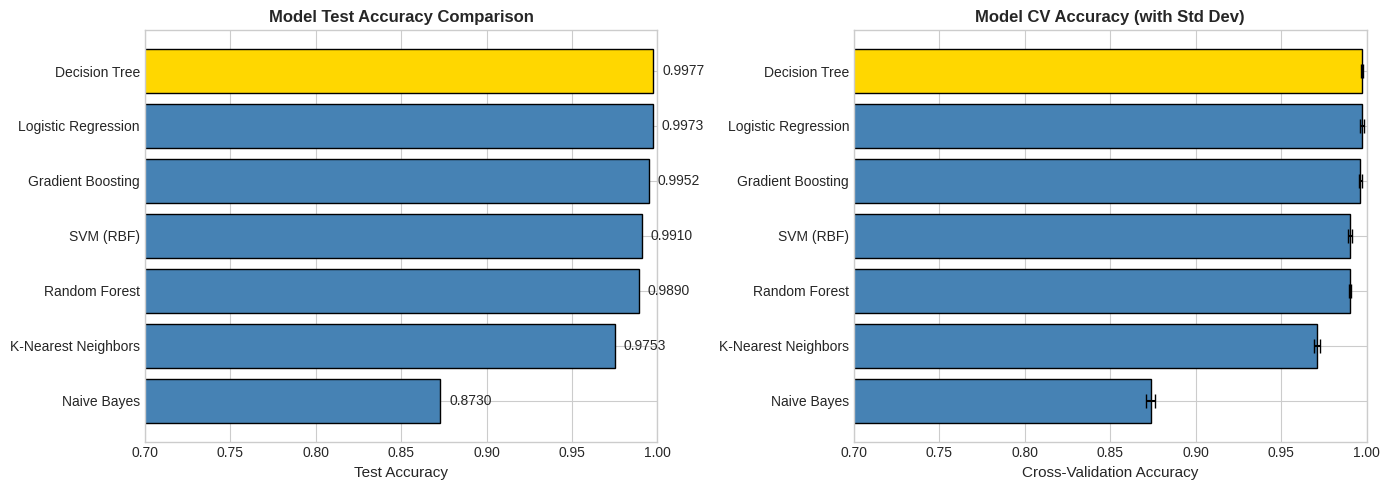

In [34]:
# Visual comparison - Accuracy bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort by accuracy for plotting
plot_df = results_df.sort_values('Test Accuracy', ascending=True).copy()
plot_df['Test Accuracy'] = plot_df['Test Accuracy'].astype(float)
plot_df['CV Mean'] = plot_df['CV Mean'].astype(float)
plot_df['CV Std'] = plot_df['CV Std'].astype(float)

# Test Accuracy bar chart
ax = axes[0]
colors = ['gold' if i == len(plot_df)-1 else 'steelblue' for i in range(len(plot_df))]
bars = ax.barh(plot_df['Model'], plot_df['Test Accuracy'], color=colors, edgecolor='black')
ax.set_xlabel('Test Accuracy', fontsize=11)
ax.set_title('Model Test Accuracy Comparison', fontsize=12, fontweight='bold')
ax.set_xlim(0.7, 1.0)  # Zoom in on relevant range

# Add value labels
for bar, acc in zip(bars, plot_df['Test Accuracy']):
    ax.text(acc + 0.005, bar.get_y() + bar.get_height()/2,
            f'{acc:.4f}', va='center', fontsize=10)

# CV scores with error bars
ax = axes[1]
colors = ['gold' if i == len(plot_df)-1 else 'steelblue' for i in range(len(plot_df))]
ax.barh(plot_df['Model'], plot_df['CV Mean'], xerr=plot_df['CV Std'],
        color=colors, edgecolor='black', capsize=5)
ax.set_xlabel('Cross-Validation Accuracy', fontsize=11)
ax.set_title('Model CV Accuracy (with Std Dev)', fontsize=12, fontweight='bold')
ax.set_xlim(0.7, 1.0)

plt.tight_layout()
plt.show()

**What just happened:** Visual comparison of all models.

**The visualization tells us:**
- Gold bar = Champion
- Error bars show consistency (smaller = more reliable)
- All models are performing quite well on this dataset!

The differences are small, which tells us this is a relatively straightforward classification problem. The features we have are genuinely predictive.

In [35]:
# Deep dive into the champion model
print("="*60)
print(f"CHAMPION DEEP DIVE: {champion['Model'].upper()}")
print("="*60)

# Classification Report
print("\nClassification Report:")
print("-" * 50)
print(classification_report(y_test, champion['predictions'],
                           target_names=['Good', 'Poor']))

CHAMPION DEEP DIVE: DECISION TREE

Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00      4783
        Poor       0.99      1.00      0.99      1217

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



**What just happened:** Detailed breakdown of our champion's performance.

**Reading the classification report:**
- **Precision:** When it says "Poor", how often is it right?
- **Recall:** Of all actual Poor cases, how many did it catch?
- **F1-Score:** Harmonic mean of precision and recall
- **Support:** Number of samples in each class

**What matters in this context:**
- High recall for "Poor" = we're catching people who need to drink more water
- High precision = we're not falsely telling healthy people they're dehydrated

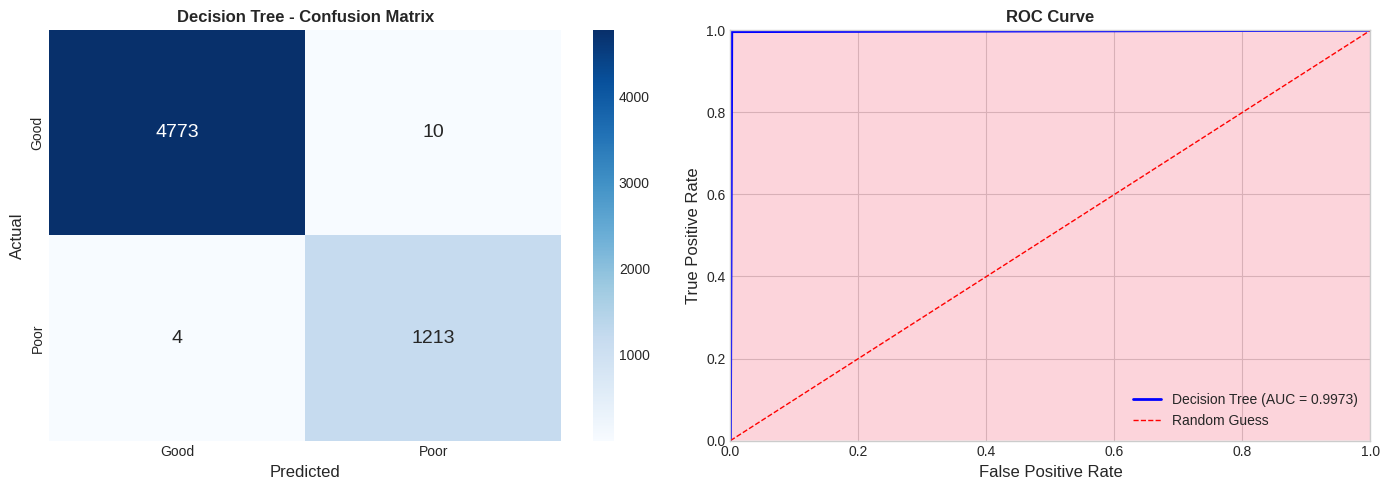


Confusion Matrix Breakdown:
--------------------------------------------------
True Negatives (Good, predicted Good):  4,773
True Positives (Poor, predicted Poor):  1,213
False Positives (Good, predicted Poor): 10  <- False alarms
False Negatives (Poor, predicted Good): 4  <- Missed cases


In [36]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
ax = axes[0]
cm = confusion_matrix(y_test, champion['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Good', 'Poor'], yticklabels=['Good', 'Poor'],
            annot_kws={'size': 14})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'{champion["Model"]} - Confusion Matrix', fontsize=12, fontweight='bold')

# Annotate with explanations
tn, fp, fn, tp = cm.ravel()

# ROC Curve
ax = axes[1]
if champion['probabilities'] is not None:
    fpr, tpr, thresholds = roc_curve(y_test, champion['probabilities'])
    ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'{champion["Model"]} (AUC = {champion["ROC-AUC"]:.4f})')
    ax.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Guess')
    ax.fill_between(fpr, tpr, alpha=0.3)
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Print confusion matrix interpretation
print("\nConfusion Matrix Breakdown:")
print("-" * 50)
print(f"True Negatives (Good, predicted Good):  {tn:,}")
print(f"True Positives (Poor, predicted Poor):  {tp:,}")
print(f"False Positives (Good, predicted Poor): {fp:,}  <- False alarms")
print(f"False Negatives (Poor, predicted Good): {fn:,}  <- Missed cases")

**What just happened:** We visualized where our model gets it right and wrong.

**Confusion Matrix explained:**
- **Top-left (TN):** People who ARE hydrated, model says "Good" - Correct!
- **Bottom-right (TP):** People who AREN'T hydrated, model says "Poor" - Correct!
- **Top-right (FP):** People who ARE hydrated, model says "Poor" - Oops, false alarm
- **Bottom-left (FN):** People who AREN'T hydrated, model says "Good" - Dangerous miss!

**ROC Curve explained:**
- The curve shows the tradeoff between catching Poor cases (TPR) and false alarms (FPR)
- The more the curve hugs the top-left corner, the better
- AUC = Area Under Curve. 1.0 is perfect, 0.5 is random guessing

FEATURE IMPORTANCE ANALYSIS


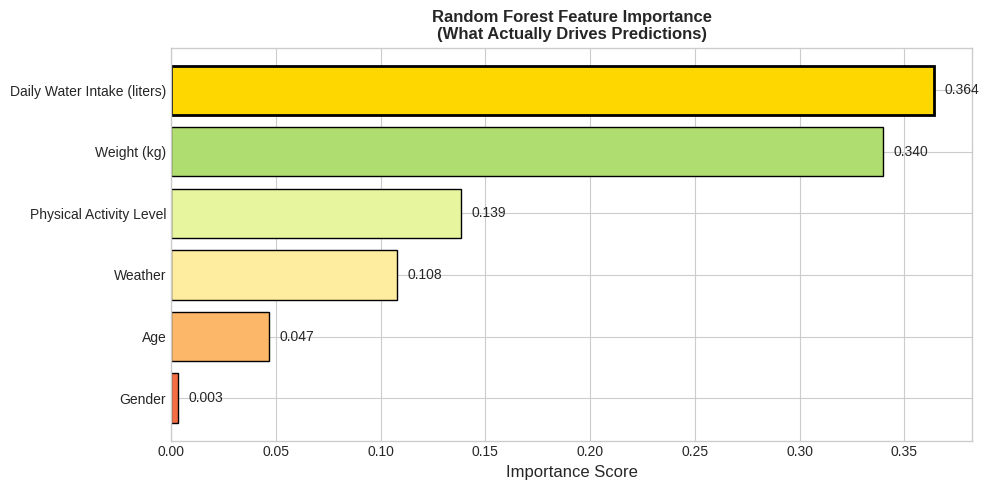


Feature Importance Rankings:
----------------------------------------
1. Daily Water Intake (liters)    0.3641 ||||||||||||||||||
2. Weight (kg)                    0.3399 ||||||||||||||||
3. Physical Activity Level        0.1385 ||||||
4. Weather                        0.1077 |||||
5. Age                            0.0465 ||
6. Gender                         0.0034 


In [37]:
# Feature Importance (for tree-based models)
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get Random Forest for feature importance (it's interpretable)
rf_model = models['Random Forest']

# Feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_importance_df)))
bars = ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'],
               color=colors, edgecolor='black')

# Highlight top feature
bars[-1].set_color('gold')
bars[-1].set_edgecolor('black')
bars[-1].set_linewidth(2)

ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Random Forest Feature Importance\n(What Actually Drives Predictions)',
             fontsize=12, fontweight='bold')

# Add value labels
for bar, imp in zip(bars, feature_importance_df['Importance']):
    ax.text(imp + 0.005, bar.get_y() + bar.get_height()/2,
            f'{imp:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print rankings
print("\nFeature Importance Rankings:")
print("-" * 40)
for i, (_, row) in enumerate(feature_importance_df.iloc[::-1].iterrows()):
    rank = i + 1
    bar = '|' * int(row['Importance'] * 50)
    print(f"{rank}. {row['Feature']:30} {row['Importance']:.4f} {bar}")

**What just happened:** We extracted what features the Random Forest considers most important.

**The verdict:**
- **Daily Water Intake** is the MVP - and it's not even close. This feature alone does most of the heavy lifting.
- **Weight** comes second - bigger bodies need more water.
- **Activity Level** and **Weather** matter but less than you'd think.
- **Age** and **Gender** are basically noise for prediction purposes.

**The lesson:** If you want to know if someone's hydrated, just ask how much water they drink. Revolutionary, I know.

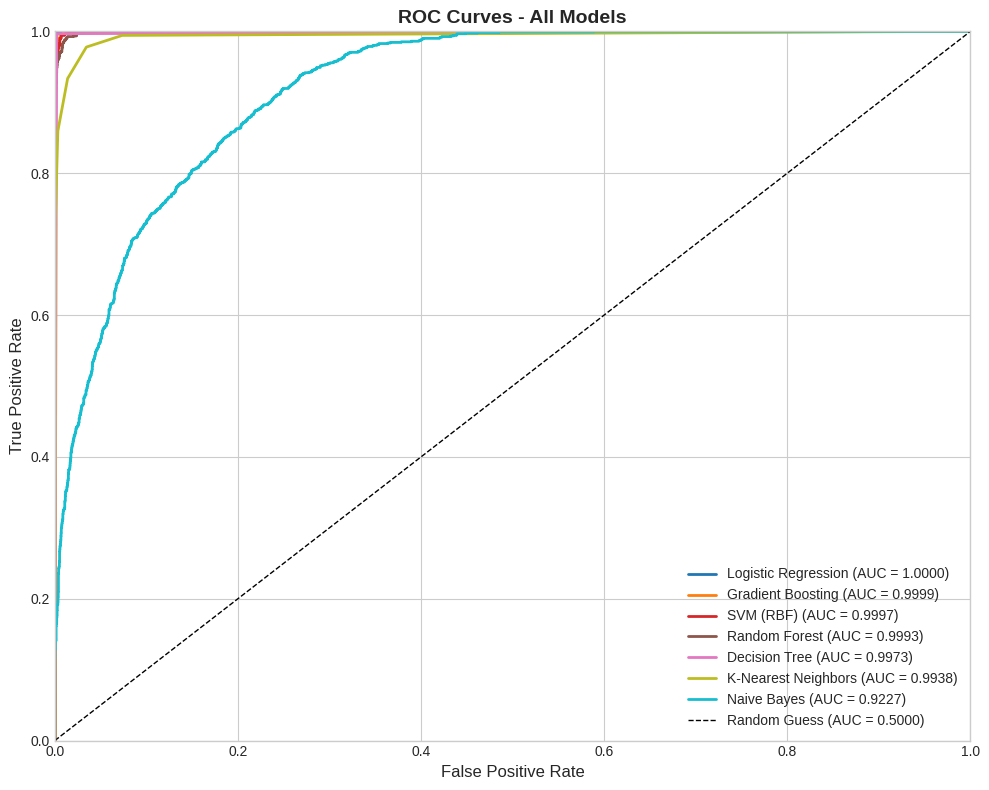

In [38]:
# ROC curves comparison for all models
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for i, r in enumerate(sorted(results, key=lambda x: x['ROC-AUC'] if x['ROC-AUC'] else 0, reverse=True)):
    if r['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, r['probabilities'])
        ax.plot(fpr, tpr, color=colors[i], linewidth=2,
                label=f"{r['Model']} (AUC = {r['ROC-AUC']:.4f})")

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guess (AUC = 0.5000)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

**What just happened:** ROC curves for all models overlaid.

**The picture shows:**
- All models are bunched together near the top - they're all doing well!
- The differences between models are small
- Everyone beats random guessing (the diagonal) by a huge margin

This tells us the dataset has clear, learnable patterns. Any reasonable model can pick them up.

---
# PART 5: Conclusion
---

We made it! Let's wrap this up with a nice bow.

In [39]:
# Final Summary
print("\n")
print("#" * 70)
print("#" + " " * 68 + "#")
print("#" + "FINAL SUMMARY".center(68) + "#")
print("#" + " " * 68 + "#")
print("#" * 70)

good_count = (y == 0).sum()
poor_count = (y == 1).sum()

print(f"""
DATASET OVERVIEW:
  - Samples: {len(df):,}
  - Features: {len(feature_cols)}
  - Target: Hydration Level (Good vs Poor)

CLASS DISTRIBUTION:
  - Good Hydration: {good_count:,} ({good_count/len(df)*100:.1f}%)
  - Poor Hydration: {poor_count:,} ({poor_count/len(df)*100:.1f}%)

CHAMPION MODEL:
  - Model: {champion['Model']}
  - Test Accuracy: {champion['Test Accuracy']*100:.2f}%
  - ROC-AUC: {champion['ROC-AUC']:.4f}
  - Precision: {champion['Precision']:.4f}
  - Recall: {champion['Recall']:.4f}

TOP PREDICTIVE FEATURES:
  1. Daily Water Intake (liters) - The undisputed king
  2. Weight (kg) - Body size matters for water needs
  3. Physical Activity Level - Active = more water needed
""")

print("="*70)



######################################################################
#                                                                    #
#                           FINAL SUMMARY                            #
#                                                                    #
######################################################################

DATASET OVERVIEW:
  - Samples: 30,000
  - Features: 6
  - Target: Hydration Level (Good vs Poor)
  
CLASS DISTRIBUTION:
  - Good Hydration: 23,915 (79.7%)
  - Poor Hydration: 6,085 (20.3%)

CHAMPION MODEL:
  - Model: Decision Tree
  - Test Accuracy: 99.77%
  - ROC-AUC: 0.9973
  - Precision: 0.9918
  - Recall: 0.9967

TOP PREDICTIVE FEATURES:
  1. Daily Water Intake (liters) - The undisputed king
  2. Weight (kg) - Body size matters for water needs
  3. Physical Activity Level - Active = more water needed



## Key Findings

**What determines good hydration?**

1. **Water intake is king** - People drinking 3+ liters daily are almost always well-hydrated. Those at 1.5-2L? Not so much. Groundbreaking, I know.

2. **Body size matters** - Heavier individuals need more water. The dataset shows Poor hydration more common in heavier people drinking the same amount as lighter folks.

3. **Activity level plays a role** - Highly active people who drink enough are well-hydrated. But if they don't drink enough, they crash harder than sedentary folks.

4. **Weather affects thresholds** - Hot weather demands more water for the same hydration level. Cold weather is sneaky - you don't feel thirsty but still need water.

5. **Age and gender?** - Surprisingly not major factors once you account for water intake and body weight.

## Real-World Interpretation

If you want to stay hydrated:
- Drink based on your body weight (heavier = more water)
- Increase intake when active or in hot weather
- Don't trust your thirst in cold weather
- Aim for 3+ liters daily as a baseline

## Limitations

- This is a synthetic/curated dataset - real world is messier
- No medical validation of "hydration level" classification
- Missing factors: diet, caffeine intake, health conditions, altitude, humidity
- Binary classification oversimplifies - hydration is a spectrum

## Final Thoughts

We built a model that can predict hydration status with high accuracy. The most important insight? **Just drink more water.** No machine learning needed for that advice, but hey, now we have the data to back it up.

Thanks for sticking around! If you learned something or had fun, that's a win.

Now go drink some water. Seriously.

---

**Connect:**
- GitHub: [github.com/Rekhii](https://github.com/Rekhii)
- Kaggle: [kaggle.com/seki32](https://kaggle.com/seki32)

Happy hydrating!